<a href="https://colab.research.google.com/github/andremshi/healthdataprep/blob/main/mortality_alzheimer_rapids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!nvidia-smi

Wed Dec 27 12:11:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 2.27 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 649.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 693.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install kmodes

In [4]:
!pip install efficient-apriori

In [5]:
!pip install arulesviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00


In [6]:
import cudf as pd
pd.__version__

'23.12.01'

In [7]:
import csv
import seaborn as sns
#import pandas as pd
#import numpy as np
import gc
#from numpy import unique
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from kmodes.kmodes import KModes
import plotly.graph_objects as go
import re
#pd.options.mode.chained_assignment = None  # default='warn'
import cupy as np


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Definition of Functions

In [9]:
# Collects mortality and CIDs datasets and selects Alzheimer's mortality
def select_dataset(refer):
  if refer == 'CID_SUBCAT':
    df = pd.read_csv('/content/drive/MyDrive/Mortalidade/CID-10-SUBCATEGORIAS2.CSV', sep=';')
    df = df[['SUBCAT','DESCRICAO']]
    df.columns = ['cid','descricao']
  elif refer == 'CID_CAT':
    df = pd.read_csv('/content/drive/MyDrive/Mortalidade/CID-10-CATEGORIAS2.CSV', sep=';')
    df = df[['CAT','DESCRICAO']]
    df.columns = ['cid','descricao']
    print('Categories CID rows: {}'.format(df.shape))
  elif refer == 'UF':
    df = pd.read_csv('/content/drive/MyDrive/Mortalidade/IBGE.csv', sep=';')
  else:
    df_temp = pd.read_csv(f'/content/drive/MyDrive/Mortalidade/Mortalidade_Geral_{refer}.csv', sep=';', dtype='unicode')
    df = df_temp[df_temp.CAUSABAS.str.startswith(('G30'))]
    print('Dataset: {} , Total rows: {}, Alzheimer rows: {}'.format(refer, df_temp.shape, df.shape))
    del df_temp
  gc.collect()
  return df


In [10]:
def delete_attributes(df, type_delete):
  #Delete columns with inconsistent values - excluding columns that are not in all datasets
  if type_delete == 'inconsistent':
    if df.name == 'df22':
      columns_delete = ['OPOR_DO', 'TP_ALTERA', 'CB_ALT']
    else:
      columns_delete = ['ESTABDESCR', 'NUDIASOBIN', 'NUDIASINF', 'FONTESINF']

  # According to data privacy, we excluded the variables "CONTADOR" and "NUMEROLOTE"
  if type_delete == 'privacy':
    if df.name == 'df22':
      columns_delete = ['contador', 'NUMEROLOTE']
    else:
      columns_delete = ['CONTADOR', 'NUMEROLOTE']

  # Delete columns with missing values (NaN)
  if type_delete == 'missing':
    columns_delete = ['IDADEMAE', 'ESCMAE', 'ESCMAE2010', 'SERIESCMAE', 'OCUPMAE',
                            'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'SEMAGESTAC', 'GESTACAO',
                            'PARTO', 'OBITOPARTO', 'PESO', 'CB_PRE', 'ACIDTRAB',
                            'FONTE', 'CAUSAMAT', 'ESCMAEAGR1', 'TPRESGINFO', 'DTCADINF',
                            'MORTEPARTO', 'DTCONCASO']
  # Delete columns with variance zero
  if type_delete == 'variance_zero':
    columns_delete = ['TIPOBITO', 'CODIFICADO', 'ALTCAUSA']

  # Delete columns with many NaN
  if type_delete == 'many_missings':
    columns_delete = ['SERIESCFAL', 'TPMORTEOCO', 'OBITOGRAV','OBITOPUERP',
                      'EXAME', 'CIRURGIA', 'COMUNSVOIM', 'CIRCOBITO', 'DTINVESTIG',
                      'FONTEINV','NUDIASOBCO','DTCADINV','TPOBITOCOR','DTCONINV','FONTES',
                      'TPNIVELINV']
  #Delete date or time type attributes
  if type_delete == 'date':
    columns_delete = ['DTOBITO', 'HORAOBITO', 'DTATESTADO', 'DTCADASTRO', 'DTRECEBIM', 'DTRECORIGA', 'DIFDATA']

  #Delete redundant attributes from other columns
  if type_delete == 'redundant':
    columns_delete = ['NATURAL','DTNASC','ESC','CAUSABAS_O','ESCFALAGR1']


  #Delete attributes with low variance and few values
  if type_delete == 'low_variance_few':
    columns_delete = ['ORIGEM','STDOEPIDEM','STDONOVA']

  #Delete irrelevants attributes (Informações irrelevantes como códigos de procedimentos internos ou informações do estabelecimentos
  #                               que não temos acesso, informações sobre o software instalado como versão, foram excluídos )
  if type_delete == 'irrelevant':
    columns_delete = ['OCUP','CODESTAB', 'CODMUNNATU', 'LINHAII', 'TPPOS', 'ATESTANTE', 'STCODIFICA', 'VERSAOSCB', 'VERSAOSIST', 'ATESTADO', 'LOCOCOR','CODMUNOCOR']

   # Delete columns categoricals with many NaN and ignored values
  if type_delete == 'many_missing_ignored':
    columns_delete = ['ASSISTMED','NECROPSIA']

  df.drop(columns_delete, axis = 1, inplace = True)
  print(f'After deleting {type_delete} attributes: {df.shape} \n')
  return df


In [11]:
def delete_rows(df, type_delete, attribute_delete, option_delete = 9):
  #Delete inconsistents rows with age = 999
  if type_delete == 'inconsistent' and attribute_delete == 'IDADE':
    indexDelete = df[df['IDADE'] == 999].index
    df.drop(indexDelete , inplace=True)

  #Delete rows with race is NaN or option =9
  if (type_delete == 'missing' and attribute_delete != 'LINHAA, LINHAB, LINHAC, LINHAD'):
    df.dropna(subset=[attribute_delete], inplace=True)
    indexDelete = df[df[attribute_delete] == option_delete].index
    df.drop(indexDelete , inplace=True)

  #Delete rows with causas is NaN
  if (type_delete == 'missing' and attribute_delete == 'LINHAA, LINHAB, LINHAC, LINHAD'):
    df.dropna(subset=['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD'], how='all', inplace=True)

  print(f'After deleting {type_delete} rows from {attribute_delete}: {df.shape} \n')

  return df

In [12]:
#Integrate datasets, excluding inconsistent columns that are not in all datasets
def integrate_dataset(dfs):
  df = pd.concat(dfs, ignore_index=True)
  print(f'After integrated datasets: {df.shape}')
  return df

In [13]:
#Format
def format_attributes(df, type_format):

  replace_causas = { 'G309': np.nan, 'G301': np.nan, 'G308': np.nan, 'G300': np.nan }

  if type_format == 'convert_numeric':
    columns_numeric = ['ORIGEM','CODMUNNATU','IDADE','SEXO','RACACOR','ESTCIV','ESC2010',
                      'OCUP','CODMUNRES','LOCOCOR','CODESTAB','CODMUNOCOR','ASSISTMED',
                      'NECROPSIA','ATESTANTE','STDOEPIDEM','STDONOVA']
    df[columns_numeric] = df[columns_numeric].astype(float)

  if type_format == 'IDADE':
    df['IDADE'] = df['IDADE'] - 400

  if type_format == 'LINHAA':
    df['LINHAA_t'] = df['LINHAA'].str[1:].copy()
    df['LINHAA_t'] = df['LINHAA_t'].replace(replace_causas)
    df['LINHAA'] = df['LINHAA_t']

    df.drop(['LINHAA_t'], axis = 1, inplace = True)

  if type_format == 'LINHAB':
    df['LINHAB_t'] = df['LINHAB'].str[1:].copy()
    df['LINHAB_t'] = df['LINHAB_t'].replace(replace_causas)
    df['LINHAB'] = df['LINHAB_t']
    df.drop(['LINHAB_t'], axis = 1, inplace = True)

  if type_format == 'LINHAC':
    df['LINHAC_t'] = df['LINHAC'].str[1:].copy()
    df['LINHAC_t'] = df['LINHAC_t'].replace(replace_causas)
    df['LINHAC'] = df['LINHAC_t']
    df.drop(['LINHAC_t'], axis = 1, inplace = True)

  if type_format == 'LINHAD':
    df['LINHAD_t'] = df['LINHAD'].str[1:].copy()
    df['LINHAD_t'] = df['LINHAD_t'].replace(replace_causas)
    df['LINHAD'] = df['LINHAD_t']
    df.drop(['LINHAD_t'], axis = 1, inplace = True)

  if type_format == 'CAUSABAS':
    df['CAUSABAS_t'] = df['CAUSABAS'].str[:3].copy()
    df['CAUSABAS'] = df['CAUSABAS_t']
    df.drop(['CAUSABAS_t'], axis = 1, inplace = True)

  if type_format =='categorical_nominal':

    maping_ESTCIV = {'1.0': 'Solteiro (a)', '2.0': 'Casado (a)', '3.0': 'Viúvo (a)', '4.0': 'Divorciado (a)', '5.0': 'União estável'}
    df['ESTCIV'] = df['ESTCIV'].astype(str)
    df['ESTCIV'] = df['ESTCIV'].replace(maping_ESTCIV)

    maping_ESC2010 = {'0.0': 'Sem escolaridade', '1.0': 'Fundamental I', '2.0': 'Fundamental II', '3.0': 'Ensino médio', '4.0': 'Superior incompleto', '5': 'Superior completo'}
    df['ESC2010'] = df['ESC2010'].astype(str)
    df['ESC2010'] = df['ESC2010'].replace(maping_ESC2010)

    maping_RACACOR = {'1.0': 'Branca', '2.0':'Preta', '3.0': 'Amarela', '4.0':'Parda', '5.0':'Indígena'}
    df['RACACOR'] = df['RACACOR'].astype(str)
    df['RACACOR'] = df['RACACOR'].replace(maping_RACACOR)

    maping_SEXO = {'1.0': 'Masculino', '2.0':'Feminino'}
    df['SEXO'] = df['SEXO'].astype(str)
    df['SEXO'] = df['SEXO'].replace(maping_SEXO)

    maping_REGIAO = {'1': 'Nordeste', '2':'Norte', '3':'Sudeste', '4':'Sul', '5':'Centro-Oeste'}
    df['REGIAO'] = df['REGIAO'].astype(str)
    df['REGIAO'] = df['REGIAO'].replace(maping_REGIAO)

  if type_format =='categorical_numeric':
    maping_IDADE = {'< 51': 0, '51 - 60': 1, '61 - 70': 2, '71 - 80': 3, '81 - 90': 4, '> 90': 5}
    df['FAIXA_IDADE'] = df['IDADE'].replace(maping_IDADE).astype(str)

  print(f'After {type_format} attributes formatted: {df.shape} \n')

  return df

In [14]:
def transformation_binning(df, attribute_transformation):
  faixas = [0, 51, 61, 71, 81, 91, float('inf')]
  rotulos = ['< 51', '51 - 60', '61 - 70', '71 - 80', '81 - 90', '> 90']

  df[attribute_transformation] = pd.cut(df[attribute_transformation], bins=faixas, labels=rotulos, right=False)

  print(f'After IDADE binning: {df.shape} \n')

  return df

In [15]:
#Create new UF attributes originating from CODMUNRES and delete column CODMUNRES
def create_attributes(df, attribute_create):
  if attribute_create == 'UF':
    df['UF'] = df['CODMUNRES'].astype(str).str[:2].astype(int)
    df['REGIAO'] = df['CODMUNRES'].astype(str).str[:1].astype(int)
    df.drop(['CODMUNRES'], axis = 1, inplace = True)

    print(f'After the new {attribute_create} attribute: {df.shape}')

  if attribute_create in ['CAUSABAS']:
    df[f'{attribute_create}'] = df[f'{attribute_create}'].str[:3]
    print(f'After the new {attribute_create}s attribute: {df.shape} \n')

  if attribute_create in ['LINHAA','LINHAB','LINHAC','LINHAD']:
    new_cols = df[attribute_create].str.split('*', expand=True)
    if len(new_cols.columns) >= 1:  # Ajuste este valor para o número mínimo de colunas esperado
      for i in range(len(new_cols.columns)):
          df[f'{attribute_create}{i + 1}'] = new_cols[i].str[:3]
    df.drop([attribute_create], axis = 1, inplace = True)

    print(f'After the new {attribute_create}s attribute: {df.shape} \n')

  return df

In [16]:
def replace_missing(df,attribute_missing):
  df[attribute_missing].fillna(df['CAUSABAS'], inplace=True)
  return df

In [17]:
def transformation_dummies(df, col_categ):
  one_hot_enc = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore'), col_categ), remainder='passthrough')
  df = one_hot_enc.fit_transform(df)
  df = pd.DataFrame(df, columns=one_hot_enc.get_feature_names_out())
  return df

In [18]:
# Check duplicate records
def check_duplicated(df):
  print(f'Check number of Duplicates: {df.duplicated().sum()} \n')

In [19]:
# Check columns with variance zero
def check_variance_zero(df):
  unique_values = df.nunique().reset_index()
  unique_values.columns = ['coluna','unico']
  columns_unique_values = unique_values.loc[unique_values['unico']==1,'coluna']
  print(f'Check columns with variance zero: \n {columns_unique_values} \n')

In [20]:
# Check columns with many nan
def check_many_nan(df, limit_perc):
  porcentagem_nans_column = (df.isna().sum()/df.shape[0])*100
  columns_many_nans = porcentagem_nans_column[porcentagem_nans_column > limit_perc]
  return print(f'Check columns with many NaN values: \n {columns_many_nans} \n')

In [21]:
# Check columns with many nan and ignored values
def check_many_nan_ignored(df, limit_perc):
  df_float = df.select_dtypes(include='float')
  porcentagem_nans_column = ((df_float.isna().sum() + df_float[df_float==9].count())/df_float.shape[0])*100
  columns_many_nans = porcentagem_nans_column[porcentagem_nans_column > limit_perc]
  return print(f'Check columns with many NaN and Ignorado values: \n {columns_many_nans} \n')


In [22]:
# Check columns with many nan
def check_many_nan_ignore(df, limit_perc):
  porcentagem_nans_column = (df.isna().sum()/df.shape[0])*100
  columns_many_nans = porcentagem_nans_column[porcentagem_nans_column > limit_perc]
  return print(f'Check columns with more than {limit_perc}% NaN values: {columns_many_nans} \n')

In [23]:
# Check columns with nan values
def check_nan_values(df):
  nan_values = df.isna().all().reset_index()
  nan_values.columns = ['coluna','nulo']
  columns_nan_values = nan_values.loc[nan_values['nulo']==True,'coluna']
  print(f'Check columns with NaN values: \n {columns_nan_values} \n')

In [24]:
# Check columns with low variance and few values
def check_low_variance_few_values(df, limit_variance, limit_values):
  results = {'Attribute': [], 'Different_values': [], 'Variance': []}
  df_float = df.select_dtypes(include='float')
  results['Attribute'].extend(df_float.columns)
  results['Different_values'].extend(df_float.nunique())
  results['Variance'].extend(df_float.var())
  df_variance = pd.DataFrame(results)
  df_variance = df_variance[(df_variance['Variance'] <= limit_variance) & (df_variance['Different_values'] <= limit_values)]

  return print(f'Check Columns with low variance and few values: \n {df_variance.head()} \n')

In [25]:
#checks if codes from dataframe 1 are in the other dataframe 2
def check_isin(df1, df2, attribute_df1, attribute_df2 ):
  all_contains = df1[attribute_df1].isin(df2[attribute_df2]).all()
  if not all_contains:
    df3 = df1[~df1[attribute_df1].isin(df2[attribute_df2])]
  else:
    df3 = ""
  print(f'Check if {attribute_df1}s from main df are in the secondary dataframe: {all_contains} \n')
  return df3

In [26]:
def remove_duplicates_causas(lista):
  nova_lista = []
  for sublista in lista:
      nova_sublista = []
      valores_unicos = set()  # Usar um conjunto para rastrear os valores únicos
      for valor in sublista:
       if valor not in valores_unicos:
         nova_sublista.append(valor)
         valores_unicos.add(valor)
      nova_lista.append(nova_sublista)
  print(f'After removing duplicate rows from the list: {len(nova_lista)}')
  return nova_lista

In [27]:
def show_shapes():
  print(df16.shape, df17.shape, df18.shape, df19.shape, df20.shape, df21.shape, df22.shape, df_subcat.shape, df_cat.shape, df_uf.shape)

In [28]:
# Evaluate cost of k numbers of clusters for k_Modes
def evaluate_k_cost(df2):
  custo = []
  for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, n_init = 2, verbose=0, random_state = 0)
    kmode.fit_predict(df2.to_pandas())
    custo.append(kmode.cost_)

    #Huang (1998) - https://link.springer.com/article/10.1023/A:1009769707641
    #https://www.geeksforgeeks.org/k-mode-clustering-in-python/

    sns.lineplot(data=custo,marker='o',color='red')
    #plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Costs (Dissimilarity)');


In [29]:
def generate_chart_distribuition(df2_1):
    #plt.figure(figsize=(10,2))
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(28,11))
    #fig, ax =plt.subplots(1,2)
    sns.countplot(x='IDADE', data=df2_1, ax=ax[0,0],order = df2_1["IDADE"].value_counts().index)
    sns.countplot(x='SEXO', data=df2_1, ax=ax[0,1],order = df2_1["SEXO"].value_counts().index)
    sns.countplot(x='RACACOR', data=df2_1, ax=ax[0,2],order = df2_1["RACACOR"].value_counts().index)
    sns.countplot(x='ESTCIV', data=df2_1, ax=ax[1,0], order = df2_1["ESTCIV"].value_counts().index)
    sns.countplot(x='ESC2010', data=df2_1, ax=ax[1,1], order = df2_1["ESC2010"].value_counts().index)
    sns.countplot(x='REGIAO', data=df2_1, ax=ax[1,2], order = df2_1["REGIAO"].value_counts().index)


    freq_idade = df2_1['IDADE'].value_counts(ascending=False).values
    perc_idade = df2_1['IDADE'].value_counts(ascending=False, normalize=True).values*100
    lbls_idade = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(freq_idade, perc_idade)]

    freq_sexo = df2_1['SEXO'].value_counts(ascending=False)
    perc_sexo = df2_1['SEXO'].value_counts(ascending=False, normalize=True).values*100
    lbls_sexo = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(freq_sexo, perc_sexo)]

    freq_racacor = df2_1['RACACOR'].value_counts(ascending=False)
    perc_racacor = df2_1['RACACOR'].value_counts(ascending=False, normalize=True).values*100
    lbls_racacor = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(freq_racacor, perc_racacor)]

    freq_estciv = df2_1['ESTCIV'].value_counts(ascending=False)
    perc_estciv = df2_1['ESTCIV'].value_counts(ascending=False, normalize=True).values*100
    lbls_estciv = [f'{p[0]:.0f} ({p[1]:.1f}%)' for p in zip(freq_estciv, perc_estciv)]

    freq_esc = df2_1['ESC2010'].value_counts(ascending=False)
    perc_esc = df2_1['ESC2010'].value_counts(ascending=False, normalize=True).values*100
    lbls_esc = [f'{p[0]:.0f} ({p[1]:.1f}%)' for p in zip(freq_esc, perc_esc)]

    freq_regiao = df2_1['REGIAO'].value_counts(ascending=False)
    perc_regiao = df2_1['REGIAO'].value_counts(ascending=False, normalize=True).values*100
    lbls_regiao = [f'{p[0]:.0f} ({p[1]:.1f}%)' for p in zip(freq_regiao, perc_regiao)]


    ax[0,0].set(xlabel='Idade', ylabel='Quantidade')
    ax[0,0].bar_label(container=ax[0,0].containers[0], labels=lbls_idade, padding=2)
    ax[0,1].set(xlabel='Sexo', ylabel='Quantidade')
    ax[0,1].bar_label(container=ax[0,1].containers[0], labels=lbls_sexo, padding=2)
    ax[0,2].set(xlabel='Raça / Cor', ylabel='Quantidade')
    ax[0,2].bar_label(container=ax[0,2].containers[0], labels=lbls_racacor, padding=2)
    ax[1,0].set(xlabel='Estado Civil', ylabel='Quantidade')
    ax[1,0].bar_label(container=ax[1,0].containers[0], labels=lbls_estciv, padding=2)
    ax[1,1].set(xlabel='Escolaridade', ylabel='Quantidade')
    ax[1,1].bar_label(container=ax[1,1].containers[0], labels=lbls_esc, padding=2)
    ax[1,2].set(xlabel='Região', ylabel='Quantidade')
    ax[1,1].set_xticklabels(['Sem Esc.', 'Fundam. I', 'Fundam. II','Médio','Sup Incompl.', 'Sup Compl.'])
    ax[1,2].bar_label(container=ax[1,2].containers[0], labels=lbls_regiao, padding=2)


    fig.show()

In [30]:
def generate_chart(df3, attribute_analysed, v_width=800, v_height=600):

  data, v_title = select_data_chart(df3, attribute_analysed)

  cores_personalizadas = ['red', 'blue', 'darkorange', 'green']

  df_res = pd.DataFrame(data)
  df_res = df_res.to_pandas()

  # Calcula as porcentagens em relação ao total por grupo e cores
  df_res['Porcentagem'] = ((df_res['Frequencia'] / df_res.groupby('Grupo')['Frequencia'].transform('sum')) * 100).round(1)


  fig = go.Figure()

  for i, grupo in enumerate(df_res['Grupo'].unique()):
      df_grupo = df_res[df_res['Grupo'] == grupo]


      fig.add_trace(go.Scatter(
          x=df_grupo[attribute_analysed], y=[grupo] * len(df_grupo),
          mode='markers+text',
          marker=dict(color=cores_personalizadas[i],
                      size=df_grupo['Porcentagem']),
          text=df_grupo['Porcentagem'].apply(lambda x: f'{x:.1f}%'),
          hoverinfo='text+x+y',
          name=grupo,
          textfont=dict(color=cores_personalizadas[i])
      ))

  fig.update_traces(textposition='bottom center', textfont=dict(size=20))
  fig.update_layout(width=v_width, height=v_height, xaxis_title=v_title, font=dict(size=18, color="black"),
      xaxis=dict(tickfont=dict(size=20, color="black")),
      yaxis=dict(tickfont=dict(size=20, color="black")))
  fig.update_traces(marker=dict(line=dict(width=2, color="black"))                 )
  fig.update_xaxes(linewidth=2, linecolor='black', mirror=True)
  fig.update_yaxes(linewidth=2, linecolor='black', mirror=True)
  fig.update_layout(plot_bgcolor="#FFFFFF")
  fig.update_layout(showlegend=False)

  #fig.add_annotation(y=0,x=4.5,
  #          text=df_res[df_res['Grupo']=='Grupo 0']['Frequencia'].sum().astype(str),
  #          showarrow=False,
  #          arrowhead=0,
  #          font=dict(
  #              color="black",
  #              size=20
  #          ))

  fig.show()

In [31]:
def select_data_chart(df3, attribute_analysed):

  v_title = attribute_analysed

  if attribute_analysed == 'Idade':
    v_title = 'Faixa de Idade'
    data = {
          'Grupo': ['Grupo 0']*5 + ['Grupo 1']*5 + ['Grupo 2']*5 + ['Grupo 3']*5,
          'Idade': ['< 61', '61 - 70', '71 - 80', '81 - 90', '> 90']*4,
          'Frequencia': [df3[(df3['IDADE'] == '< 51') & (df3['GRUPO']==0)]['IDADE'].count()+df3[(df3['IDADE'] == '51 - 60') & (df3['GRUPO']==0)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '61 - 70') & (df3['GRUPO']==0)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '71 - 80') & (df3['GRUPO']==0)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '81 - 90') & (df3['GRUPO']==0)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '> 90') & (df3['GRUPO']==0)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '< 51') & (df3['GRUPO']==1)]['IDADE'].count()+df3[(df3['IDADE'] == '51 - 60') & (df3['GRUPO']==1)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '61 - 70') & (df3['GRUPO']==1)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '71 - 80') & (df3['GRUPO']==1)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '81 - 90') & (df3['GRUPO']==1)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '> 90') & (df3['GRUPO']==1)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '< 51') & (df3['GRUPO']==2)]['IDADE'].count()+df3[(df3['IDADE'] == '51 - 60') & (df3['GRUPO']==2)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '61 - 70') & (df3['GRUPO']==2)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '71 - 80') & (df3['GRUPO']==2)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '81 - 90') & (df3['GRUPO']==2)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '> 90') & (df3['GRUPO']==2)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '< 51') & (df3['GRUPO']==3)]['IDADE'].count()+df3[(df3['IDADE'] == '51 - 60') & (df3['GRUPO']==3)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '61 - 70') & (df3['GRUPO']==3)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '71 - 80') & (df3['GRUPO']==3)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '81 - 90') & (df3['GRUPO']==3)]['IDADE'].count(),
                        df3[(df3['IDADE'] == '> 90') & (df3['GRUPO']==3)]['IDADE'].count()
                        ]
      }
  if attribute_analysed == 'Sexo':
    data = {
            'Grupo': ['Grupo 0']*2 + ['Grupo 1']*2 + ['Grupo 2']*2 + ['Grupo 3']*2,
            'Sexo': ['Feminino','Masculino']*4,
            'Frequencia': [ df3[(df3['SEXO'] == 'Feminino') & (df3['GRUPO']==0)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Masculino') & (df3['GRUPO']==0)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Feminino') & (df3['GRUPO']==1)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Masculino') & (df3['GRUPO']==1)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Feminino') & (df3['GRUPO']==2)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Masculino') & (df3['GRUPO']==2)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Feminino') & (df3['GRUPO']==3)]['SEXO'].count(),
                            df3[(df3['SEXO'] == 'Masculino') & (df3['GRUPO']==3)]['SEXO'].count(),
                          ]
    }

  if attribute_analysed == 'Raca':
    v_title = 'Raça / Cor'
    data = {
            'Grupo': ['Grupo 0']*5 + ['Grupo 1']*5 + ['Grupo 2']*5 + ['Grupo 3']*5,
            'Raca': ['Branca','Preta','Amarela','Parda','Indígena']*4,
            'Frequencia':  [df3[(df3['RACACOR'] == 'Branca') & (df3['GRUPO']==0)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Preta') & (df3['GRUPO']==0)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Amarela') & (df3['GRUPO']==0)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Parda') & (df3['GRUPO']==0)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Indígena') & (df3['GRUPO']==0)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Branca') & (df3['GRUPO']==1)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Preta') & (df3['GRUPO']==1)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Amarela') & (df3['GRUPO']==1)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Parda') & (df3['GRUPO']==1)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Indígena') & (df3['GRUPO']==1)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Branca') & (df3['GRUPO']==2)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Preta') & (df3['GRUPO']==2)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Amarela') & (df3['GRUPO']==2)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Parda') & (df3['GRUPO']==2)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Indígena') & (df3['GRUPO']==2)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Branca') & (df3['GRUPO']==3)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Preta') & (df3['GRUPO']==3)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Amarela') & (df3['GRUPO']==3)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Parda') & (df3['GRUPO']==3)]['RACACOR'].count(),
                            df3[(df3['RACACOR'] == 'Indígena') & (df3['GRUPO']==3)]['RACACOR'].count()
                            ]

    }
  if attribute_analysed == 'Estado_Civil':
    v_title = 'Estado Civil'
    data = {
          'Grupo': ['Grupo 0']*5 + ['Grupo 1']*5 + ['Grupo 2']*5 + ['Grupo 3']*5,
          'Estado_Civil': ['Solteiro (a)','Casado (a)','Viúvo (a)','Divorciado (a)','União estável']*4,
          'Frequencia':  [df3[(df3['ESTCIV'] == 'Solteiro (a)') & (df3['GRUPO']==0)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Casado (a)') & (df3['GRUPO']==0)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Viúvo (a)') & (df3['GRUPO']==0)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Divorciado (a)') & (df3['GRUPO']==0)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'União estável') & (df3['GRUPO']==0)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Solteiro (a)') & (df3['GRUPO']==1)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Casado (a)') & (df3['GRUPO']==1)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Viúvo (a)') & (df3['GRUPO']==1)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Divorciado (a)') & (df3['GRUPO']==1)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'União estável') & (df3['GRUPO']==1)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Solteiro (a)') & (df3['GRUPO']==2)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Casado (a)') & (df3['GRUPO']==2)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Viúvo (a)') & (df3['GRUPO']==2)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Divorciado (a)') & (df3['GRUPO']==2)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'União estável') & (df3['GRUPO']==2)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Solteiro (a)') & (df3['GRUPO']==3)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Casado (a)') & (df3['GRUPO']==3)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Viúvo (a)') & (df3['GRUPO']==3)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'Divorciado (a)') & (df3['GRUPO']==3)]['ESTCIV'].count(),
                          df3[(df3['ESTCIV'] == 'União estável') & (df3['GRUPO']==3)]['ESTCIV'].count()
                         ]
    }

  if attribute_analysed == 'Escolaridade':
    data = {
            'Grupo': ['Grupo 0']*6 + ['Grupo 1']*6 + ['Grupo 2']*6 + ['Grupo 3']*6,
            'Escolaridade': ['Sem escolaridade', 'Fundamental I', 'Fundamental II', 'Ensino médio', 'Superior incompleto', 'Superior completo']*4,
            'Frequencia': [df3[(df3['ESC2010'] == 'Sem escolaridade') & (df3['GRUPO']==0)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental I') & (df3['GRUPO']==0)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental II') & (df3['GRUPO']==0)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Ensino médio') & (df3['GRUPO']==0)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior incompleto') & (df3['GRUPO']==0)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior completo') & (df3['GRUPO']==0)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Sem escolaridade') & (df3['GRUPO']==1)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental I') & (df3['GRUPO']==1)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental II') & (df3['GRUPO']==1)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Ensino médio') & (df3['GRUPO']==1)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior incompleto') & (df3['GRUPO']==1)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior completo') & (df3['GRUPO']==1)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Sem escolaridade') & (df3['GRUPO']==2)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental I') & (df3['GRUPO']==2)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental II') & (df3['GRUPO']==2)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Ensino médio') & (df3['GRUPO']==2)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior incompleto') & (df3['GRUPO']==2)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior completo') & (df3['GRUPO']==2)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Sem escolaridade') & (df3['GRUPO']==3)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental I') & (df3['GRUPO']==3)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Fundamental II') & (df3['GRUPO']==3)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Ensino médio') & (df3['GRUPO']==3)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior incompleto') & (df3['GRUPO']==3)]['ESC2010'].count(),
                          df3[(df3['ESC2010'] == 'Superior completo') & (df3['GRUPO']==3)]['ESC2010'].count()
                          ]

    }
  if attribute_analysed == 'Regiao':
    v_title = 'Região'
    data = {
    'Grupo': ['Grupo 0']*5 + ['Grupo 1']*5 + ['Grupo 2']*5 + ['Grupo 3']*5,
    'Regiao': ['Centro-Oeste','Norte','Nordeste','Sudeste','Sul']*4,
    'Frequencia': [df3[(df3['REGIAO'] == 'Centro-Oeste') & (df3['GRUPO']==0)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Norte') & (df3['GRUPO']==0)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Nordeste') & (df3['GRUPO']==0)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sudeste') & (df3['GRUPO']==0)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sul') & (df3['GRUPO']==0)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Centro-Oeste') & (df3['GRUPO']==1)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Norte') & (df3['GRUPO']==1)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Nordeste') & (df3['GRUPO']==1)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sudeste') & (df3['GRUPO']==1)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sul') & (df3['GRUPO']==1)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Centro-Oeste') & (df3['GRUPO']==2)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Norte') & (df3['GRUPO']==2)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Nordeste') & (df3['GRUPO']==2)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sudeste') & (df3['GRUPO']==2)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sul') & (df3['GRUPO']==2)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Centro-Oeste') & (df3['GRUPO']==3)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Norte') & (df3['GRUPO']==3)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Nordeste') & (df3['GRUPO']==3)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sudeste') & (df3['GRUPO']==3)]['REGIAO'].count(),
                   df3[(df3['REGIAO'] == 'Sul') & (df3['GRUPO']==3)]['REGIAO'].count()
                   ]

    }
  return data, v_title

In [32]:
def prepare_data(df, df_uf):

  #Show columns with missing values
  check_nan_values(df)

  # Delete columns with only missing values ( delete 22 atributtes)
  df = delete_attributes(df,'missing')

  #Chech Duplicates
  check_duplicated(df)

  # Checl variance zero
  check_variance_zero(df)

  #Delete 3 atributtes with variance zero
  df = delete_attributes(df,'variance_zero')

  #Check columns with Nan above 75%
  check_many_nan(df, 75)

  #Delete 16 attributes with NaN above 75%
  df = delete_attributes(df,'many_missings')

  #Delete 7 date or time type attributes
  df = delete_attributes(df, 'date')

  #Delete 5 columns that have redundant information from other columns
  df = delete_attributes(df, 'redundant')

  #Formatar string em numerico
  df = format_attributes(df,'convert_numeric')

  #Check low variance
 #check_low_variance_few_values(df, 0.01, 3)

  #Delete 3 columns with low variance and few values
  df = delete_attributes(df,'low_variance_few')

  #Delete 12 attributes 'OCUP','CODESTAB', 'CODMUNNATU' 'LINHAII', 'TPPOS', 'ATESTANTE', 'STCODIFICA', 'VERSAOSCB', 'VERSAOSIST', 'ATESTADO', 'LOCOCOR', 'CODMUNOCOR'
  # Informações irrelevantes como códigos de procedimentos internos ou informações do estabelecimentos
  #que não temos acesso, informações sobre o software instalado como versão, foram excluídos
  df = delete_attributes(df,'irrelevant')

  ##Check columns with NaN and ignored values (option =9) above 30% for categorical attributes
  check_many_nan_ignored(df, 30)

  #Delete columns with NaN and ignored values (option =9) above 30% for categorical attributes
  df = delete_attributes(df,'many_missing_ignored')

  #Delete inconsistent values of Age (7 rows)
  df = delete_rows(df, 'inconsistent','IDADE')

  ##Delete rows with race is NaN or option =9 (3703 rows)
  df = delete_rows(df,'missing','RACACOR',9)

  ##Delete rows with estado civil is NaN or option =9 (7544 rows)
  df = delete_rows(df,'missing','ESTCIV',9)

  ##Delete rows with escolaridade is NaN or option =9 (20137 rows)
  df = delete_rows(df,'missing','ESC2010',9)

  ##Delete rows with sexo is NaN or option =9 (3 rows)
  df = delete_rows(df,'missing','SEXO',0)

  #Format age attribute
  df = format_attributes(df,'IDADE')

  #Create new UF attributes originating from CODMUNRES and delete column CODMUNRES
  df = create_attributes(df,'UF')

  #checks if all UFs are true by consulting the IBGE database
  check_isin(df, df_uf, 'UF','CODIGO')

  return df


In [33]:
# Select datasets -  Alzheimer's mortality
def collect_select():
  df16 = select_dataset('2016')
  df17 = select_dataset('2017')
  df18 = select_dataset('2018')
  df19 = select_dataset('2019')
  df20 = select_dataset('2020')
  df21 = select_dataset('2021')
  df22 = select_dataset('2022')
  df_subcat = select_dataset('CID_SUBCAT')
  df_cat = select_dataset('CID_CAT')
  df_uf = select_dataset('UF')

  #Name dataframe
  df16.name = 'df16'
  df17.name = 'df17'
  df18.name = 'df18'
  df19.name = 'df19'
  df20.name = 'df20'
  df21.name = 'df21'
  df22.name = 'df22'

  return df16, df17, df18, df19, df20, df21, df22, df_subcat, df_cat, df_uf

# Data Preparation

In [34]:
df16, df17, df18, df19, df20, df21, df22, df_subcat, df_cat, df_uf = collect_select()

Dataset: 2016 , Total rows: (1309774, 87), Alzheimer rows: (18409, 87)
Dataset: 2017 , Total rows: (1312663, 87), Alzheimer rows: (19844, 87)
Dataset: 2018 , Total rows: (1316719, 87), Alzheimer rows: (20594, 87)
Dataset: 2019 , Total rows: (1349801, 87), Alzheimer rows: (23150, 87)
Dataset: 2020 , Total rows: (1556824, 87), Alzheimer rows: (23855, 87)
Dataset: 2021 , Total rows: (1832649, 87), Alzheimer rows: (25542, 87)
Dataset: 2022 , Total rows: (1542158, 86), Alzheimer rows: (29040, 86)
Categories CID rows: (2045, 2)


In [35]:
#df16.shape, df17.shape, df18.shape, df19.shape, df20.shape, df21.shape, df22.shape, df_c.shape
show_shapes()

(18409, 87) (19844, 87) (20594, 87) (23150, 87) (23855, 87) (25542, 87) (29040, 86) (12451, 2) (2045, 2) (27, 2)


In [36]:
# Delete columns with inconsistent values - excluding columns that are not in all datasets
# Delete 3 atributtes in 2022 file and 4 atributes in 2016 until 2021
df16 = delete_attributes(df16, 'inconsistent')
df17 = delete_attributes(df17, 'inconsistent')
df18 = delete_attributes(df18, 'inconsistent')
df19 = delete_attributes(df19, 'inconsistent')
df20 = delete_attributes(df20, 'inconsistent')
df21 = delete_attributes(df21, 'inconsistent')
df22 = delete_attributes(df22, 'inconsistent')


After deleting inconsistent attributes: (18409, 83) 

After deleting inconsistent attributes: (19844, 83) 

After deleting inconsistent attributes: (20594, 83) 

After deleting inconsistent attributes: (23150, 83) 

After deleting inconsistent attributes: (23855, 83) 

After deleting inconsistent attributes: (25542, 83) 

After deleting inconsistent attributes: (29040, 83) 



In [37]:
# Delete columns that can identify people (delete 2 atributtes)
df16 = delete_attributes(df16, 'privacy')
df17 = delete_attributes(df17, 'privacy')
df18 = delete_attributes(df18, 'privacy')
df19 = delete_attributes(df19, 'privacy')
df20 = delete_attributes(df20, 'privacy')
df21 = delete_attributes(df21, 'privacy')
df22 = delete_attributes(df22, 'privacy')

After deleting privacy attributes: (18409, 81) 

After deleting privacy attributes: (19844, 81) 

After deleting privacy attributes: (20594, 81) 

After deleting privacy attributes: (23150, 81) 

After deleting privacy attributes: (23855, 81) 

After deleting privacy attributes: (25542, 81) 

After deleting privacy attributes: (29040, 81) 



In [38]:
df = integrate_dataset([df16, df17, df18, df19, df20, df21, df22])
#df_tempo = integrate_dataset([df16, df17, df18, df19, df20, df21, df22])

After integrated datasets: (160434, 81)


In [39]:
df = prepare_data(df, df_uf)

Check columns with NaN values: 
 19      IDADEMAE
20        ESCMAE
21    ESCMAE2010
22    SERIESCMAE
23       OCUPMAE
24    QTDFILVIVO
25    QTDFILMORT
26      GRAVIDEZ
27    SEMAGESTAC
28      GESTACAO
29         PARTO
30    OBITOPARTO
31          PESO
45        CB_PRE
49      ACIDTRAB
64      CAUSAMAT
65    ESCMAEAGR1
75    TPRESGINFO
77      DTCADINF
78    MORTEPARTO
79     DTCONCASO
Name: coluna, dtype: object 

After deleting missing attributes: (160434, 59) 

Check number of Duplicates: 0 

Check columns with variance zero: 
 1       TIPOBITO
41    CODIFICADO
58      ALTCAUSA
Name: coluna, dtype: object 

After deleting variance_zero attributes: (160434, 56) 

Check columns with many NaN values: 
 SERIESCFAL    77.712330
TPMORTEOCO    99.712654
OBITOGRAV     99.710161
OBITOPUERP    99.710161
EXAME         99.733847
CIRURGIA      99.742573
LINHAD        78.356832
COMUNSVOIM    92.695439
CIRCOBITO     99.978807
DTINVESTIG    86.336437
FONTEINV      85.893265
NUDIASOBCO    99.970704

In [40]:
#def calcular_porcentagens(coluna):
    #contagem = coluna.value_counts()
    #porcentagens = contagem / contagem.sum() * 100
    #return contagem, porcentagens
#resultados_origem = calcular_porcentagens(df['ORIGEM'])
#resultados_stdepidem = calcular_porcentagens(df['STDOEPIDEM'])
#resultados_stdnova = calcular_porcentagens(df['STDONOVA'])

# Criar DataFrames a partir dos resultados
#df_origem = pd.DataFrame({'Contagem': resultados_origem[0], 'Porcentagem': resultados_origem[1]})
#df_stdepidem = pd.DataFrame({'Contagem': resultados_stdepidem[0], 'Porcentagem': resultados_stdepidem[1]})
#df_stdnova = pd.DataFrame({'Contagem': resultados_stdnova[0], 'Porcentagem': resultados_stdnova[1]})

# Imprimir os resultados
#print("Resultados ORIGEM:")
#print(df_origem)

#print("\nResultados STDOEPIDEM:")
#print(df_stdepidem)

#print("\nResultados STDONOVA:")
#print(df_stdnova)


In [41]:
df_causas = df[['LINHAA', 'LINHAB','LINHAC', 'LINHAD']]

In [42]:
df.drop(['LINHAA','LINHAB','LINHAC','LINHAD','UF','CAUSABAS'], axis = 1, inplace = True)
df_num = df.copy()
#df = format_attributes(df, 'categorical_nominal')

In [43]:
# Retired character '*' at the beginning of the attribute
df_causas = format_attributes(df_causas, 'LINHAA')
df_causas = format_attributes(df_causas, 'LINHAB')
df_causas = format_attributes(df_causas, 'LINHAC')
df_causas = format_attributes(df_causas, 'LINHAD')
#df_causas = format_attributes(df_causas, 'CAUSABAS')


After LINHAA attributes formatted: (129040, 4) 

After LINHAB attributes formatted: (129040, 4) 

After LINHAC attributes formatted: (129040, 4) 

After LINHAD attributes formatted: (129040, 4) 



In [44]:
df_causas = delete_rows(df_causas,'missing', 'LINHAA, LINHAB, LINHAC, LINHAD')

After deleting missing rows from LINHAA, LINHAB, LINHAC, LINHAD: (119083, 4) 



In [45]:
df_causas.head()

,LINHAA,LINHAB,LINHAC,LINHAD
0,J189,<NA>,<NA>,<NA>
1,J180,<NA>,<NA>,<NA>
4,A419,J690,E86X*E43X,<NA>
5,R688,E46X,<NA>,<NA>
6,A419,<NA>,J159,L89X


In [46]:
# create new attributes originating from the split and delete original columns
#df_causas = create_attributes(df_causas,'CAUSABAS')
df_causas = create_attributes(df_causas,'LINHAA')
df_causas = create_attributes(df_causas,'LINHAB')
df_causas = create_attributes(df_causas,'LINHAC')
df_causas = create_attributes(df_causas,'LINHAD')

df_causas = df_causas.replace({None: np.nan})

After the new LINHAAs attribute: (119083, 7) 

After the new LINHABs attribute: (119083, 10) 

After the new LINHACs attribute: (119083, 13) 

After the new LINHADs attribute: (119083, 16) 



In [47]:
df_causas.head()

,LINHAA1,LINHAA2,LINHAA3,LINHAA4,LINHAB1,LINHAB2,LINHAB3,LINHAB4,LINHAC1,LINHAC2,LINHAC3,LINHAC4,LINHAD1,LINHAD2,LINHAD3,LINHAD4
0,J18,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,J18,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,A41,<NA>,<NA>,<NA>,J69,<NA>,<NA>,<NA>,E86,E43,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,R68,<NA>,<NA>,<NA>,E46,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,A41,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,J15,<NA>,<NA>,<NA>,L89,<NA>,<NA>,<NA>


In [48]:
# Replace missing CIDs values with standard Alzheimer's cid (CAUSABAS)
#df = replace_missing(df,'LINHAA1')
#df = replace_missing(df,'LINHAA2')
#df = replace_missing(df,'LINHAA3')
#df = replace_missing(df,'LINHAA4')
#df = replace_missing(df,'LINHAB1')
#df = replace_missing(df,'LINHAB2')
#df = replace_missing(df,'LINHAB3')
#df = replace_missing(df,'LINHAB4')
#df = replace_missing(df,'LINHAC1')
#df = replace_missing(df,'LINHAC2')
#df = replace_missing(df,'LINHAC3')
#df = replace_missing(df,'LINHAC4')
#df = replace_missing(df,'LINHAD1')
#df = replace_missing(df,'LINHAD2')
#df = replace_missing(df,'LINHAD3')
#df = replace_missing(df,'LINHAD4')

In [49]:
#check_result, df_result = check_isin(df, df_cid, 'LINHAA2','cid')
#df_result['LINHAA2'].value_counts()

In [50]:
# Attributes transformation with binning
df1 = df.copy()
df2 = transformation_binning(df, 'IDADE')

After IDADE binning: (129040, 6) 



In [51]:
# Reset index
df2.reset_index(drop=True,inplace=True)
df1.reset_index(drop=True,inplace=True)
df_causas.reset_index(drop=True,inplace=True)

In [52]:
#df3 = transformation_dummies(df2, ['IDADE','SEXO'])

In [53]:
df2_1 = format_attributes(df2, 'categorical_nominal')

After categorical_nominal attributes formatted: (129040, 6) 



# Clustering

CPU times: user 7min 7s, sys: 22.8 s, total: 7min 30s
Wall time: 7min 9s


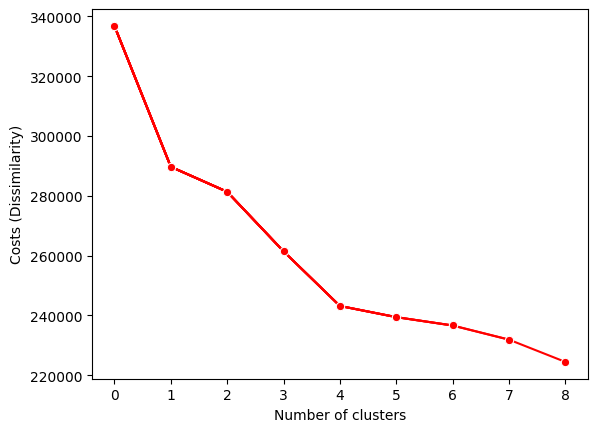

In [54]:
%%time
evaluate_k_cost(df2)

In [55]:
%%time
#K-Modes Fit and Predict
kmd = KModes(n_clusters=5, verbose=1, init='Cao', random_state = 0)
clusters = kmd.fit_predict(df2_1.to_pandas())
print(kmd.cluster_centroids_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 243147.0
[['81 - 90' 'Feminino' 'Branca' 'Viúvo (a)' 'Fundamental I' 'Sudeste']
 ['> 90' 'Masculino' 'Branca' 'Casado (a)' 'Sem escolaridade' 'Sul']
 ['71 - 80' 'Feminino' 'Branca' 'Casado (a)' 'Ensino médio' 'Norte']
 ['71 - 80' 'Masculino' 'Parda' 'Casado (a)' 'Fundamental I' 'Sudeste']
 ['> 90' 'Feminino' 'Parda' 'Viúvo (a)' 'Sem escolaridade' 'Norte']]
CPU times: user 49.3 s, sys: 2.82 s, total: 52.1 s
Wall time: 49.4 s


In [56]:
from collections import Counter, defaultdict
print(Counter(kmd.labels_))

Counter({0: 80466, 1: 16199, 3: 12251, 4: 10944, 2: 9180})


In [57]:
agrupamento = pd.DataFrame(clusters, columns = ['GRUPO'])
df3 = pd.concat([df2_1, agrupamento],axis=1)

In [58]:
#df4 = format_attributes(df4, 'categorical_nominal')

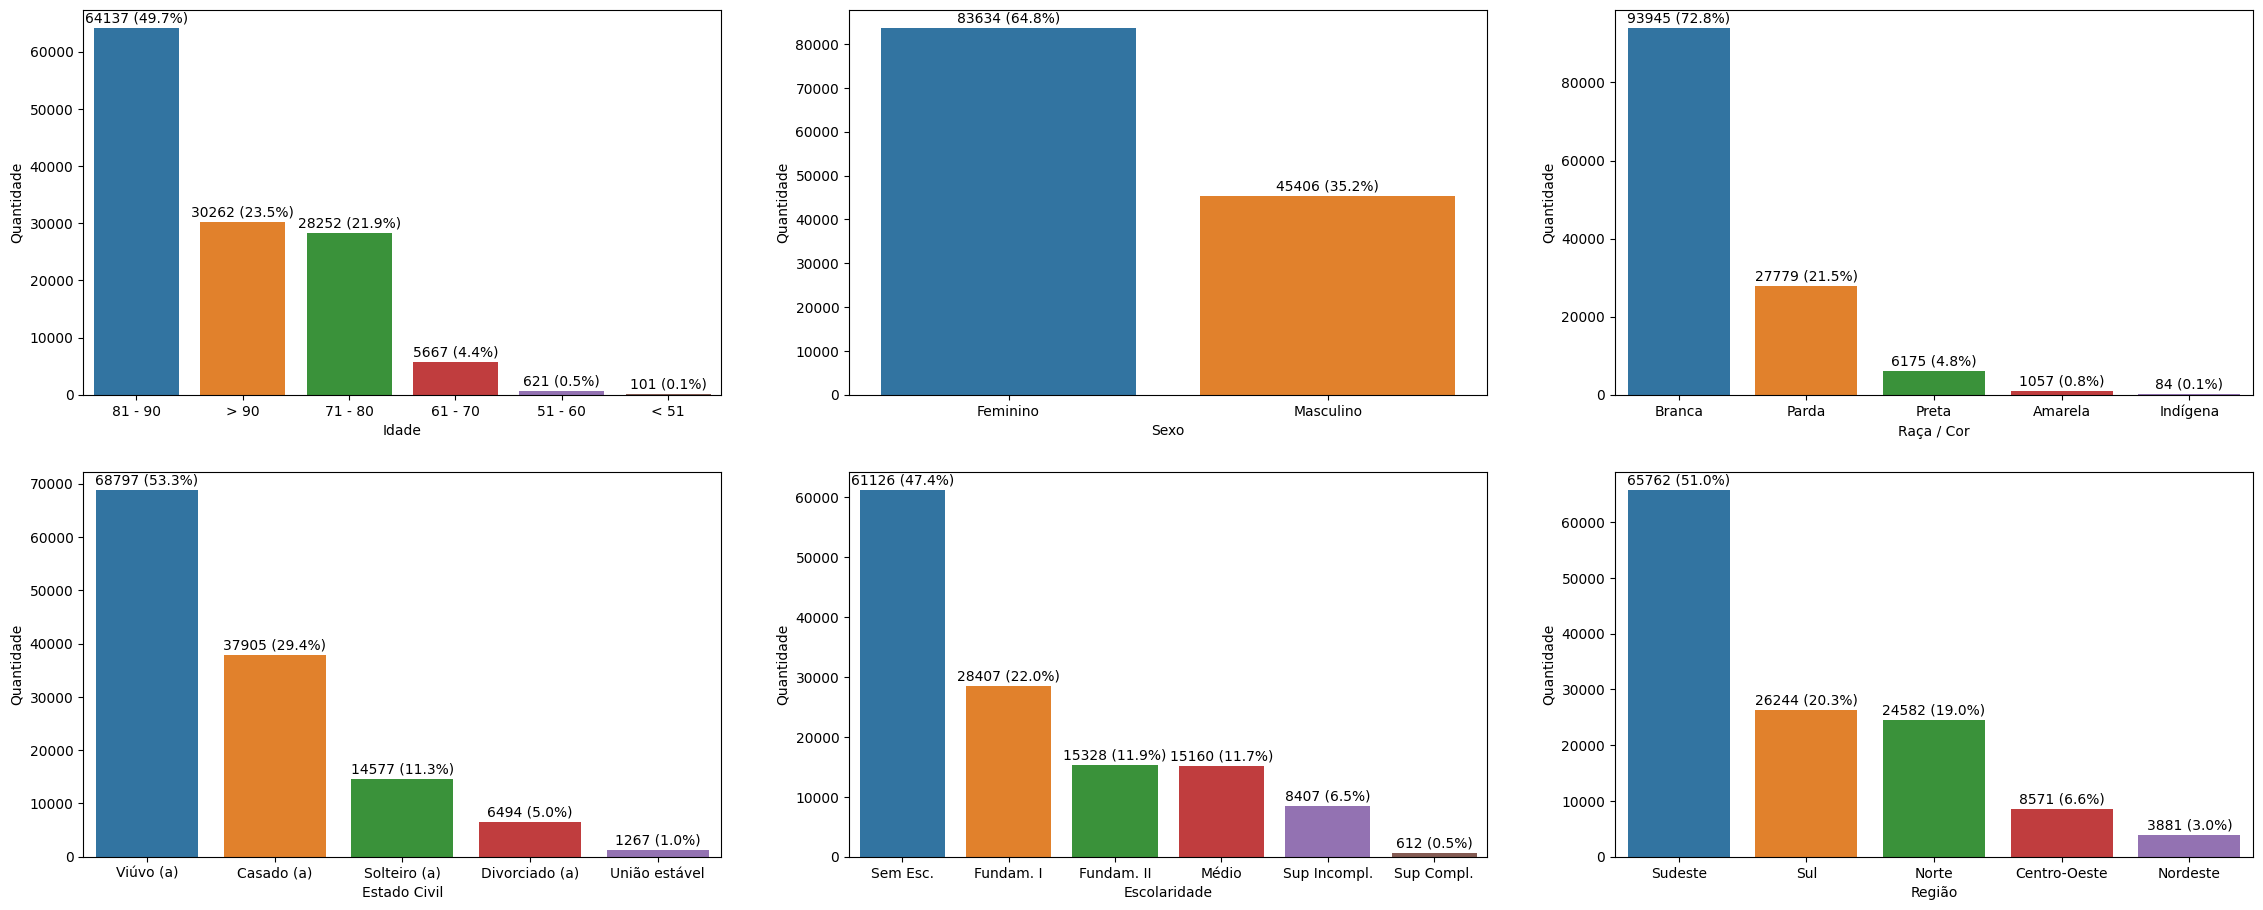

In [59]:
generate_chart_distribuition(df2_1.to_pandas())


In [60]:
generate_chart(df3, 'Idade', 800, 600)

In [61]:
generate_chart(df3, 'Sexo', 600, 700)

In [62]:
generate_chart(df3, 'Raca', 800, 700)

In [63]:
generate_chart(df3, 'Estado_Civil', 800, 600)

In [64]:
generate_chart(df3, 'Escolaridade', 800, 700)

In [65]:
generate_chart(df3, 'Regiao', 800, 600)

# Rules Association

In [66]:
from efficient_apriori import apriori
import pandas as pd2

In [67]:
# Convert/Format the dataframe into a list of lists
lista_causas = []
df_causas2 = df_causas.to_pandas()
for i in range(len(df_causas)):
  lista_causas.append([str(df_causas2.values[i, j]) for j in range(df_causas2.shape[1]) if pd2.notna(df_causas2.values[i, j])])


In [68]:
lista_causas = remove_duplicates_causas(lista_causas)

After removing duplicate rows from the list: 119083


In [69]:
# Execute apriori and Generate Rules Association
results_rules = {'Antecedent': [], 'Consequent': [], 'Support': [], 'Confidence': [], 'Lift': [], 'RPF': [], 'Conviction': []}
str_ruleslhs = ''

itemsets, rules = apriori(lista_causas, min_support = 0.02, min_confidence = 0.3)
for rule in rules:

  results_rules['Antecedent'].append(', '.join(rule.lhs))
  results_rules['Consequent'].append(', '.join(rule.rhs))
  results_rules['Support'].append(rule.support)
  results_rules['Confidence'].append(rule.confidence)
  results_rules['Lift'].append(rule.lift)
  results_rules['RPF'].append(rule.rpf)
  results_rules['Conviction'].append(rule.conviction)
df_rules = pd.DataFrame(results_rules)
df_rules = df_rules.sort_values(by = 'Confidence', ascending = False)
df_rules['% Support'] = ((df_rules['Support']*100).round(2)).astype(str) + '%'
df_rules['% Confidence'] = ((df_rules['Confidence']*100).round(2)).astype(str)+ '%'
df_rules['Lift'] = df_rules['Lift'].round(2)

df_rules[['Antecedent','Consequent','% Support','% Confidence','Lift']]

,Antecedent,Consequent,% Support,% Confidence,Lift
4,L89,A41,2.48%,72.34%,2.55
5,N39,A41,2.55%,58.37%,2.06
2,A41,J18,13.19%,46.48%,1.50
0,J15,A41,3.36%,44.38%,1.56
1,J18,A41,13.19%,42.49%,1.50
6,J96,J18,8.83%,38.1%,1.23
3,J69,A41,3.86%,36.29%,1.28
7,J69,J96,3.59%,33.73%,1.46


In [70]:
print('Generate strong rules:', df_rules.shape[0])

Generate strong rules: 8


In [71]:
df_cat[df_cat['cid'].isin(['A41','L89','N39','J96','J18','J15','J96','J69'])]

,cid,descricao
35,A41,Outras septicemias
720,J15,Pneumonia bacteriana não classificada em outra...
723,J18,Pneumonia por microorganismo não especificada
754,J69,Pneumonite devida a sólidos e líquidos
768,J96,Insuficiência respiratória não classificada de...
904,L89,Úlcera de decúbito
1029,N39,Outros transtornos do trato urinário


In [72]:
# Prepare Items sets to generate chart
itens = []
quantidades = []

for k, v in itemsets.items():
    for item, quantidade in v.items():
        itens.append(', '.join(item))
        quantidades.append(quantidade)
df_itens = pd.DataFrame({'cid': itens, 'mortes': quantidades})
df_itens = df_itens.sort_values(by = 'mortes', ascending = False)
df_itens['porcentagem'] = ((df_itens['mortes'] / df_itens['mortes'].sum()) * 100).round(2)

In [73]:
print('Generate items set: ', df_itens.shape[0])



Generate items set:  27


In [74]:
df_itens_10 = pd.merge(df_itens.head(10), df_cat, how="left", on=['cid','cid'])
df_itens_10.reset_index(inplace=True)

In [75]:
df_itens_10.loc[df_itens_10['cid'] == 'A41, J18', 'descricao'] = 'Outras septicemias + Pneumonia por microorganismo não especificada'
df_itens_10.loc[df_itens_10['cid'] == 'J18, J96', 'descricao'] = 'Pneumonia por microorganismo não especificada + Insuficiência respiratória não classificada de outra parte'
df_itens_10['Descrição'] = df_itens_10['cid'] + ' - ' + df_itens_10['descricao']
df_itens_10 = df_itens_10.to_pandas()


In [76]:
import plotly.express as px

fig = px.bar(df_itens_10, x=df_itens_10['cid'], y=df_itens_10['porcentagem'],
             color='Descrição',
             height=500, width=1400,
             labels={'porcentagem':'% Conjunto de Itens', 'cid': 'CID - Outras causas'},
             text=df_itens_10['porcentagem'].astype(str)+'%')
fig.show()

In [77]:
import plotly.graph_objects as go
df_rules2 = df_rules.to_pandas()

fig = go.Figure(data=go.Scatter(
    x=df_rules2['Support']*100,
    y=df_rules2['Confidence']*100,
    mode='markers',
    text=df_rules2['Antecedent']+ '->' + df_rules2['Consequent'],
    hoverinfo='text',
    marker=dict(size=df_rules2['Lift']*30,
                color=df_rules2['Lift'],
                colorscale='Portland', # one of plotly colorscales
                showscale=True,
                colorbar=dict(
                    title="Lift"
                ))
))

fig.update_traces(textposition='middle right', textfont=dict(size=20))
fig.update_layout(width=800, height=800, xaxis_title='Support (%)', yaxis_title='Confidence (%)', font=dict(size=18, color="black"),
      xaxis=dict(tickfont=dict(size=20, color="black")),
      yaxis=dict(tickfont=dict(size=20, color="black")))
fig.update_traces(marker=dict(line=dict(width=2, color="black"))                 )
fig.update_xaxes(linewidth=2, linecolor='black')
fig.update_yaxes(linewidth=2, linecolor='black')
fig.update_layout(plot_bgcolor="#FFFFFF")


fig.update_layout(showlegend=False)



fig.show()

In [78]:

#regras = apriori(lista_causas, min_support = 0.01, min_confidence = 0.3, min_lift = 1.01, random_state =0 )

#resultados = list(regras)
#print(resultados)

In [79]:
# Prepare results for viewing
#A = []
#B = []
#suporte = []
#confianca = []
#lift = []

#for resultado in resultados:
#  s = resultado[1]
#  result_rules = resultado[2]
#  for result_rule in result_rules:
#    a = list(result_rule[0])
#    b = list(result_rule[1])
#    c = result_rule[2]
#    l = result_rule[3]
#    A.append(a)
#   B.append(b)
#   suporte.append(s)
#    confianca.append(c)
 #   lift.append(l)

In [80]:
from google.colab import output
output.enable_custom_widget_manager()


In [81]:
from arulesviz import Arulesviz

g = Arulesviz(lista_causas, 0.01, 0.3, 1.1, products_to_drop=[])
g.create_rules()
g.plot_graph(width=800, height=400, directed=True, charge=-500, link_distance=20)

In [82]:
g.plot_scatter(with_toolbar=True)

##Data Understanding - Rules Association

In [83]:
lista_causas_unica = [item for sublist in lista_causas for item in sublist]

In [84]:
itemsets

{1: {('J18',): 36980,
  ('A41',): 33807,
  ('J69',): 12658,
  ('R68',): 7927,
  ('E46',): 2770,
  ('J15',): 9005,
  ('L89',): 4085,
  ('J96',): 27608,
  ('J98',): 4177,
  ('R09',): 10438,
  ('N17',): 2404,
  ('R54',): 7211,
  ('I10',): 4226,
  ('I50',): 2899,
  ('R99',): 7725,
  ('R64',): 4022,
  ('N39',): 5193,
  ('R57',): 4343},
 2: {('A41', 'J15'): 3996,
  ('A41', 'J18'): 15712,
  ('A41', 'J69'): 4593,
  ('A41', 'J96'): 3713,
  ('A41', 'L89'): 2955,
  ('A41', 'N39'): 3031,
  ('J15', 'J96'): 2591,
  ('J18', 'J96'): 10518,
  ('J69', 'J96'): 4270}}

In [85]:
df_causas_unica = pd.DataFrame(data=lista_causas_unica, columns=['CAUSAS'])
df_top10_causas = pd.DataFrame(df_causas_unica.value_counts().head(10))
df_top10_causas.reset_index(inplace=True)
df_top10_causas.columns = ['cid','mortes']

In [86]:
df_top10_causas

,cid,mortes
0,J18,36980
1,A41,33807
2,J96,27608
3,J69,12658
4,R09,10438
5,J15,9005
6,R68,7927
7,R99,7725
8,R54,7211
9,N39,5193


In [87]:
df_top10_causas_desc = pd.merge(df_top10_causas, df_cat, how="left", on=['cid','cid'])

In [88]:
new_row = {'cid':'Total', 'mortes':len(lista_causas), 'descricao':'Total de mortes por Alzheimer'}
df_top10_causas_desc = df_top10_causas_desc.append(new_row, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/cudf/core/indexed_frame.py:3728: FutureWarning:

The append method is deprecated and will be removed in a future version. Use cudf.concat instead.



In [89]:
df_top10_causas_desc = df_top10_causas_desc.sort_values(by = 'mortes', ascending = False)

In [90]:
df_top10_causas_desc


,cid,mortes,descricao
10,Total,119083,Total de mortes por Alzheimer
0,J18,36980,Pneumonia por microorganismo não especificada
1,A41,33807,Outras septicemias
2,J96,27608,Insuficiência respiratória não classificada de...
3,J69,12658,Pneumonite devida a sólidos e líquidos
4,R09,10438,Outros sintomas e sinais relativos aos aparelh...
5,J15,9005,Pneumonia bacteriana não classificada em outra...
6,R68,7927,Outros sintomas e sinais gerais
7,R99,7725,Outras causas mal definidas e as não especific...
8,R54,7211,Senilidade


In [91]:
import plotly.express as px

fig = px.bar(df_top10_causas_desc, x='cid', y='mortes',
             color='descricao',
             height=400, width=1200,
             labels={'mortes':'Mortes', 'cid': 'CID - Outras causas'},
             text='mortes')
fig.show()